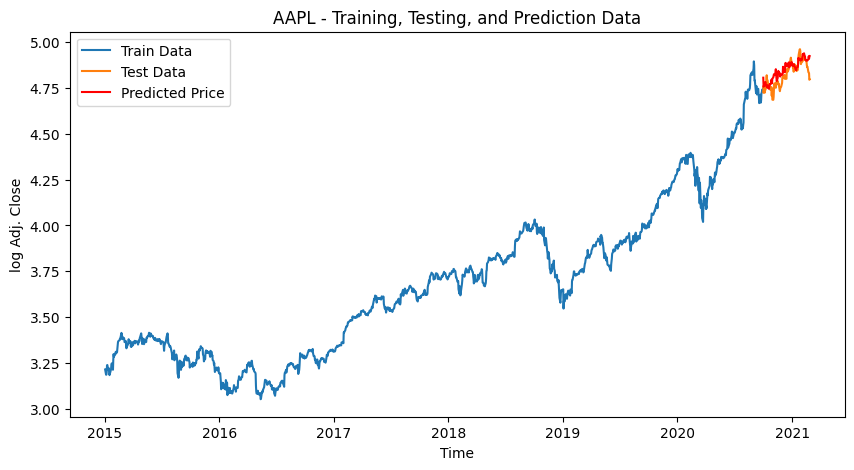


Metrics for AAPL:
MSE: 36.502141871957846
MAE: 4.694691179804102
RMSE: 6.041700246781351
MAPE: 0.03879389265807037


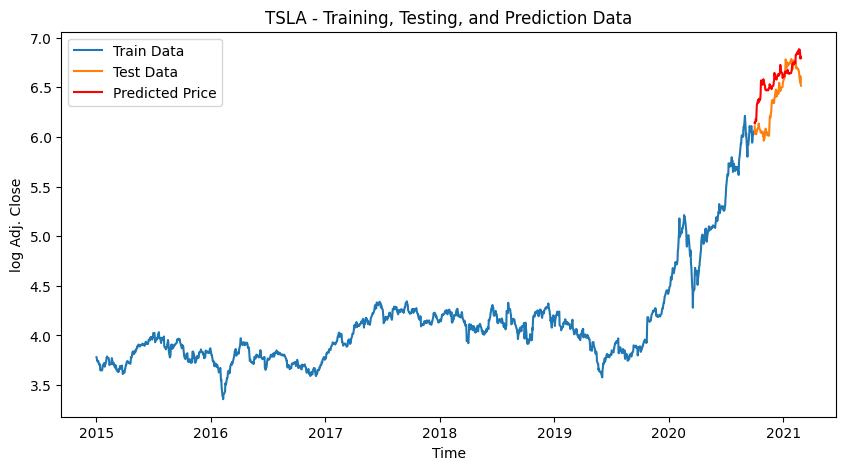


Metrics for TSLA:
MSE: 24302.76333188509
MAE: 133.35378101181018
RMSE: 155.8934358203869
MAPE: 0.2567635298252183


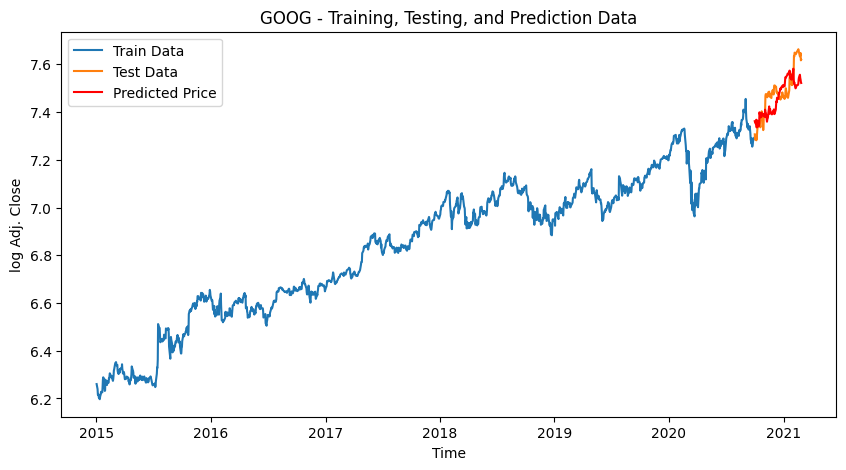


Metrics for GOOG:
MSE: 18446.10046539039
MAE: 111.51496417365004
RMSE: 135.8164219282425
MAPE: 0.06054522032532803


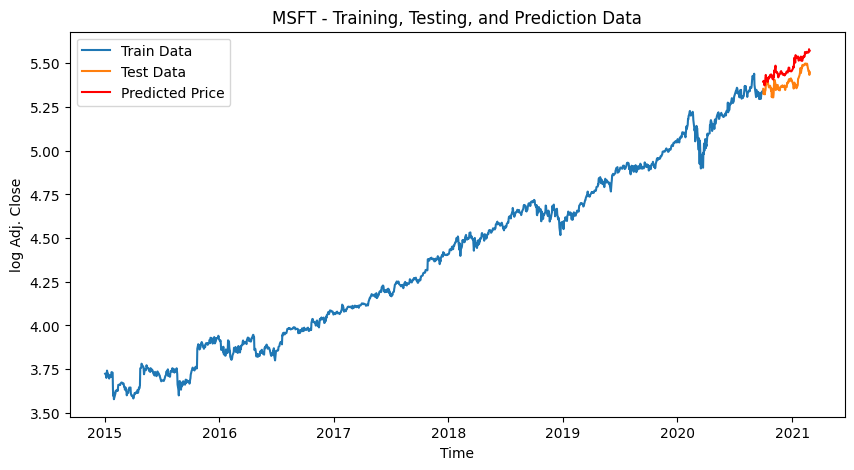


Metrics for MSFT:
MSE: 387.5125421007045
MAE: 17.872968533324066
RMSE: 19.68533825212827
MAPE: 0.08158270935600782


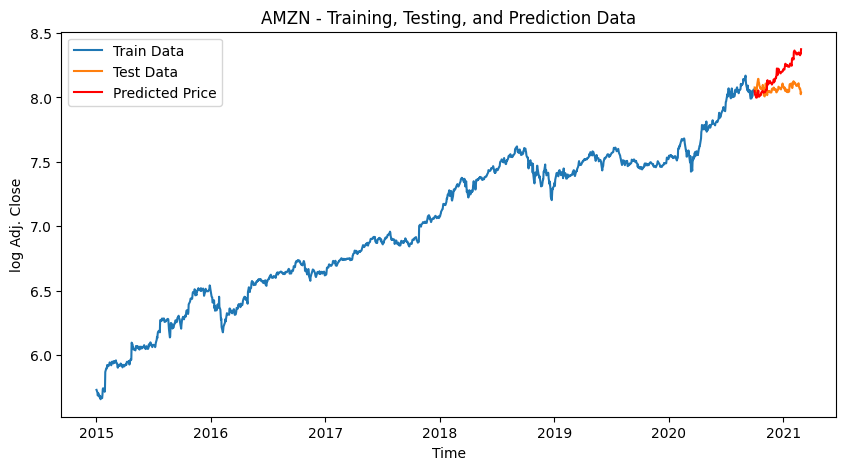


Metrics for AMZN:
MSE: 292215.1460126885
MAE: 448.4540869948018
RMSE: 540.5692795680203
MAPE: 0.13943086095243773

All Stock Evaluation Metrics saved to metrics.csv.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import math

# Set file paths
database_location = "/mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/Database/"
output_location_predictions = "/mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MarkovChain/predictions/"
output_location_metrics = "/mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MarkovChain/metrics/"

# Ensure directories exist
os.makedirs(output_location_predictions, exist_ok=True)
os.makedirs(output_location_metrics, exist_ok=True)

# Stock files
stock_files = {
    "AAPL": "Pre_Processed_AAPL.csv",
    "TSLA": "Pre_Processed_TSLA.csv",
    "GOOG": "Pre_Processed_GOOG.csv",
    "MSFT": "Pre_Processed_MSFT.csv",
    "AMZN": "Pre_Processed_AMZN.csv"
}

def run_markov_chain_simulation(stock_name, file_path, start_date, end_date, pred_end_date, k=1, threshold=5, scen_size=1000):
    # Load dataset
    np.random.seed(42) # Set seed for reproducibility
    stock_data = pd.read_csv(file_path)
    stock_data["Date"] = pd.to_datetime(stock_data["Date"])
    stock_data['log Adj. Close'] = np.log(stock_data['Adj. Close'])
    
    # Prepare data for Markov Chain simulation
    train_set = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] < end_date)].set_index('Date')
    test_set = stock_data[(stock_data['Date'] >= end_date) & (stock_data['Date'] <= pred_end_date)].set_index('Date')
    
    # Calculate percentage changes
    percentage_changes = (train_set['Adj. Close'] - train_set['Adj. Close'].shift(k)) / train_set['Adj. Close'].shift(k)
    percentage_changes = percentage_changes.dropna()

    # Divide percentage changes into bins
    bins = pd.qcut(percentage_changes, q=int(len(percentage_changes) / threshold), duplicates='drop')
    bin_labels = bins.cat.categories

    # Calculate transition probabilities
    transition_matrix = pd.DataFrame(0, index=bin_labels, columns=bin_labels)
    for i in range(len(bins) - 1):
        current_bin = bins.iloc[i]
        next_bin = bins.iloc[i + 1]
        transition_matrix.loc[current_bin, next_bin] += 1

    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

    # Function to sample from a bin
    def sample_from_bin(bin_range):
        lower, upper = bin_range.left, bin_range.right
        return np.random.uniform(lower, upper)

    # Function to get the next bin based on the current bin
    def get_next_bin(current_bin):
        probabilities = transition_matrix.loc[current_bin]
        return np.random.choice(probabilities.index, p=probabilities.values)

    # Generate scenarios using Markov Chain
    S = np.zeros((scen_size, len(test_set) + 1))
    S[:, 0] = train_set['Adj. Close'].iloc[-1]
    
    # Ensure initial bins are valid
    initial_bins = pd.cut(S[:, 0], bins=bin_labels)

    for t in range(1, len(test_set) + 1):
        for i in range(scen_size):
            current_bin = initial_bins[i]
            if pd.isna(current_bin):
                current_bin = bin_labels[0]  # Assign to the first bin if NaN
            next_bin = get_next_bin(current_bin)
            percentage_change = sample_from_bin(next_bin)
            S[i, t] = S[i, t - 1] * (1 + percentage_change)
            initial_bins[i] = next_bin

    # Calculate the predicted values
    S_max = [S[:, i].max() for i in range(len(test_set) + 1)]
    S_min = [S[:, i].min() for i in range(len(test_set) + 1)]
    S_pred = .5 * np.array(S_max) + .5 * np.array(S_min)
    
    final_df = pd.DataFrame(data=[test_set['Adj. Close'].reset_index(drop=True), S_pred[1:]], index=['real', 'pred']).T
    final_df.index = test_set.index

    # Save predictions to CSV
    final_df.to_csv(f"{output_location_predictions}{stock_name}_predictions.csv", index_label="Date", header=["Actual_Adj_Close", "Predicted_Adj_Close"])

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(train_set.index, train_set['log Adj. Close'], label='Train Data')
    plt.plot(test_set.index, np.log(test_set['Adj. Close']), label='Test Data')
    plt.plot(final_df.index, np.log(final_df['pred']), label='Predicted Price', color='red')
    plt.xlabel('Time')
    plt.ylabel('log Adj. Close')
    plt.legend(loc='best')
    plt.title(f'{stock_name} - Training, Testing, and Prediction Data')
    plt.show()
    
    # Calculate metrics
    actual_values = final_df['real'].values
    predicted_values = final_df['pred'].values

    mse = mean_squared_error(actual_values, predicted_values)
    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = math.sqrt(mse)
    non_zero_actuals = actual_values != 0
    mape = np.mean(np.abs(predicted_values[non_zero_actuals] - actual_values[non_zero_actuals]) / np.abs(actual_values[non_zero_actuals]))

    print(f"\nMetrics for {stock_name}:")
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')
    
    # Return metrics as a dictionary
    return {
        "Stock": stock_name,
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    }

# Loop through each stock and process
metrics_list = []
for stock, file in stock_files.items():
    file_path = database_location + file
    metrics = run_markov_chain_simulation(
        stock_name=stock,
        file_path=file_path,
        start_date='2015-01-02',
        end_date='2020-10-01',
        pred_end_date='2021-02-26',
        k=1,                # Lag for percentage change calculation
        threshold=5,        # Minimum number of transitions per bin
        scen_size=1000      # Number of scenarios
    )
    metrics_list.append(metrics)

# Save all metrics to a single CSV file
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv(f"{output_location_metrics}metrics.csv", index=False)

print("\nAll Stock Evaluation Metrics saved to metrics.csv.")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import math

# Define datasets with periods
datasets = {
    "Dataset-A": {
        "start_date": "2015-01-02",
        "end_date": "2020-02-26",
        "pred_end_date": "2021-02-26"
    },
    "Dataset-B": {
        "start_date": "2015-01-02",
        "end_date": "2020-08-26",
        "pred_end_date": "2021-02-26"
    }
}

# Set file paths
database_location = "/mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/Database/"
output_location_predictions = "/mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MarkovChain/predictions/"
output_location_metrics = "/mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MarkovChain/metrics/"

# Ensure base directories exist
os.makedirs(output_location_predictions, exist_ok=True)
os.makedirs(output_location_metrics, exist_ok=True)

# Stock files
stock_files = {
    "AAPL": "Pre_Processed_AAPL.csv",
    "TSLA": "Pre_Processed_TSLA.csv",
    "GOOG": "Pre_Processed_GOOG.csv",
    "MSFT": "Pre_Processed_MSFT.csv",
    "AMZN": "Pre_Processed_AMZN.csv"
}

# Function to run Markov Chain simulation
def run_markov_chain_simulation(stock_name, file_path, start_date, end_date, pred_end_date, k=1, threshold=5, scen_size=1000):
    np.random.seed(42)  # Set seed for reproducibility
    
    # Load dataset
    stock_data = pd.read_csv(file_path)
    stock_data["Date"] = pd.to_datetime(stock_data["Date"])
    stock_data['log Adj. Close'] = np.log(stock_data['Adj. Close'])
    
    # Prepare data for Markov Chain simulation
    train_set = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] < end_date)].set_index('Date')
    test_set = stock_data[(stock_data['Date'] >= end_date) & (stock_data['Date'] <= pred_end_date)].set_index('Date')
    
    # Calculate percentage changes
    percentage_changes = (train_set['Adj. Close'] - train_set['Adj. Close'].shift(k)) / train_set['Adj. Close'].shift(k)
    percentage_changes = percentage_changes.dropna()

    # Divide percentage changes into bins
    bins = pd.qcut(percentage_changes, q=int(len(percentage_changes) / threshold), duplicates='drop')
    bin_labels = bins.cat.categories

    # Calculate transition probabilities
    transition_matrix = pd.DataFrame(0, index=bin_labels, columns=bin_labels)
    for i in range(len(bins) - 1):
        current_bin = bins.iloc[i]
        next_bin = bins.iloc[i + 1]
        transition_matrix.loc[current_bin, next_bin] += 1

    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

    # Function to sample from a bin
    def sample_from_bin(bin_range):
        lower, upper = bin_range.left, bin_range.right
        return np.random.uniform(lower, upper)

    # Function to get the next bin based on the current bin
    def get_next_bin(current_bin):
        probabilities = transition_matrix.loc[current_bin]
        return np.random.choice(probabilities.index, p=probabilities.values)

    # Generate scenarios using Markov Chain
    S = np.zeros((scen_size, len(test_set) + 1))
    S[:, 0] = train_set['Adj. Close'].iloc[-1]
    
    # Ensure initial bins are valid
    initial_bins = pd.cut(S[:, 0], bins=bin_labels)

    for t in range(1, len(test_set) + 1):
        for i in range(scen_size):
            current_bin = initial_bins[i]
            if pd.isna(current_bin):
                current_bin = bin_labels[0]  # Assign to the first bin if NaN
            next_bin = get_next_bin(current_bin)
            percentage_change = sample_from_bin(next_bin)
            S[i, t] = S[i, t - 1] * (1 + percentage_change)
            initial_bins[i] = next_bin

    # Calculate the predicted values
    S_max = [S[:, i].max() for i in range(len(test_set) + 1)]
    S_min = [S[:, i].min() for i in range(len(test_set) + 1)]
    S_pred = .5 * np.array(S_max) + .5 * np.array(S_min)
    
    final_df = pd.DataFrame(data=[test_set['Adj. Close'].reset_index(drop=True), S_pred[1:]], index=['real', 'pred']).T
    final_df.index = test_set.index

    # Return predictions and test data
    return final_df

# Loop through datasets and process each stock for Markov Chain simulation
for dataset_name, period in datasets.items():
    # Create dataset-specific directories
    dataset_predictions_dir = os.path.join(output_location_predictions, dataset_name)
    dataset_metrics_dir = os.path.join(output_location_metrics, dataset_name)
    os.makedirs(dataset_predictions_dir, exist_ok=True)
    os.makedirs(dataset_metrics_dir, exist_ok=True)
    
    metrics_list = []
    
    for stock, file in stock_files.items():
        file_path = database_location + file
        
        # Run simulation for the current dataset
        final_df = run_markov_chain_simulation(
            stock_name=stock,
            file_path=file_path,
            start_date=period['start_date'],
            end_date=period['end_date'],
            pred_end_date=period['pred_end_date'],
            k=1,                # Lag for percentage change calculation
            threshold=5,        # Minimum number of transitions per bin
            scen_size=1000      # Number of scenarios
        )
        
        # Save predictions in the dataset-specific directory
        predictions_file = os.path.join(dataset_predictions_dir, f"{stock}_predictions.csv")
        final_df.to_csv(predictions_file, index_label="Date", header=["Actual_Adj_Close", "Predicted_Adj_Close"])
        print(f"Predictions saved for {stock} in {dataset_name}: {predictions_file}")
        
        # Calculate metrics
        mse = mean_squared_error(final_df['real'], final_df['pred'])
        mae = mean_absolute_error(final_df['real'], final_df['pred'])
        rmse = math.sqrt(mse)
        mape = np.mean(np.abs(final_df['pred'] - final_df['real']) / np.abs(final_df['real']))

        metrics = {
            "Stock": stock,
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape,
            "Predictions_File": predictions_file
        }
        metrics_list.append(metrics)
    
    # Save metrics for the current dataset
    metrics_df = pd.DataFrame(metrics_list)
    metrics_file = os.path.join(dataset_metrics_dir, "metrics.csv")
    metrics_df.to_csv(metrics_file, index=False)
    print(f"\nMetrics for {dataset_name} saved to {metrics_file}.")

Predictions saved for AAPL in Dataset-A: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MarkovChain/predictions/Dataset-A/AAPL_predictions.csv
Predictions saved for TSLA in Dataset-A: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MarkovChain/predictions/Dataset-A/TSLA_predictions.csv
Predictions saved for GOOG in Dataset-A: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MarkovChain/predictions/Dataset-A/GOOG_predictions.csv
Predictions saved for MSFT in Dataset-A: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MarkovChain/predictions/Dataset-A/MSFT_predictions.csv
Predictions saved for AMZN in Dataset-A: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MarkovChain/predictions/Dataset-A/AMZN_predictions.csv

Metrics for Dataset-A saved to /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MarkovChain/metrics/Dataset-A/metrics.csv.
Predictions saved for AAPL in Dataset-B: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MarkovChain/predictions/Dataset-B/AAPL_predictions.csv